In [ ]:
#Try SVC 50%/20%/30% without cross-validation

In [2]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning, message="use_inf_as_na option is deprecated")

import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns

def preprocess_data(filepath):
    try:
        df = pd.read_csv(filepath)
        if df.empty:
            return None, None
        df['Date'] = pd.to_datetime(df['Date'])
        df = df[df['Date'].dt.year <= 2017]
        df['Prev Close'] = df['Close'].shift(1)
        df['Price Change'] = (df['Close'] - df['Prev Close']) / df['Prev Close']
        df['Label'] = (df['Price Change'] > 0).astype(int)
        df.dropna(inplace=True)
        df_numeric = df.drop(['Date'], axis=1) if 'Date' in df else df
        return df, df_numeric.select_dtypes(include=[np.number])
    except pd.errors.EmptyDataError:
        return None, None

model = SVC(kernel='linear', probability=False, random_state=42)
scaler = StandardScaler()

directory_path = './new_data/tech'
filepaths = [os.path.join(directory_path, f) for f in os.listdir(directory_path) if f.endswith('.csv')]
valid_accs = []
test_accs = []

for filepath in filepaths:
    df, df_numeric = preprocess_data(filepath)

    train, temp = train_test_split(df_numeric, train_size=0.5, shuffle=False)
    validation, test = train_test_split(temp, test_size=0.6, shuffle=False)
    
    X_train = scaler.fit_transform(train.drop(['Label'], axis=1))
    y_train = train['Label']
    X_valid = scaler.transform(validation.drop(['Label'], axis=1))
    y_valid = validation['Label']
    X_test = scaler.transform(test.drop(['Label'], axis=1))
    y_test = test['Label']
    
    model.fit(X_train, y_train)
    valid_acc = accuracy_score(y_valid, model.predict(X_valid))
    test_acc = accuracy_score(y_test, model.predict(X_test))
    valid_accs.append(valid_acc)
    test_accs.append(test_acc)

avg_valid_acc = np.mean(valid_accs)
avg_test_acc = np.mean(test_accs)
print(f'Average Validation Accuracy: {avg_valid_acc:.4f}')
print(f'Average Test Accuracy: {avg_test_acc:.4f}')

Average Validation Accuracy: 0.9762
Average Test Accuracy: 0.9301


In [ ]:
# SVC 70%/30% with 3-fold cross-validation (tech)

Average cross-validation accuracy: 0.9919
Average test set accuracy: 0.9940
The accuracy of the predicted trend is: 0.7366


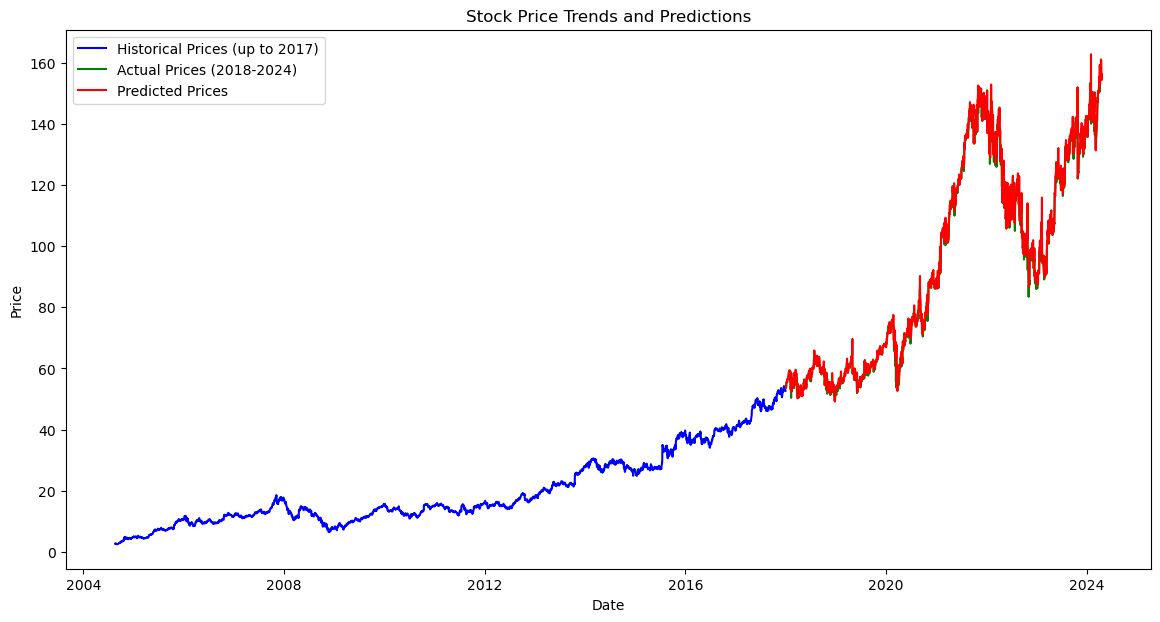

In [5]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

def preprocess_data(file_path, end_date=None):
    data = pd.read_csv(file_path)
    data['Date'] = pd.to_datetime(data['Date'])
    if end_date:
        data = data[data['Date'] <= pd.to_datetime(end_date)]
    data['Prev Close'] = data['Close'].shift(1)
    data['Price Change'] = (data['Close'] - data['Prev Close']) / data['Prev Close']
    data['Label'] = (data['Price Change'] > 0).astype(int)
    data.dropna(inplace=True)
    return data

directory_path = './new_data/tech'

model = SVC(kernel='linear')
scaler = StandardScaler()
cv_scores = []
test_scores = []

for file in os.listdir(directory_path):
    if file.endswith('.csv'):
        file_path = os.path.join(directory_path, file)
        data = preprocess_data(file_path, end_date='2017-12-31')
        X = data.drop(['Date', 'Label'], axis=1)
        y = data['Label']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        tmp_scores = cross_val_score(model, X_train_scaled, y_train, cv=3)
        cv_scores.extend(tmp_scores)

        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        test_acc = accuracy_score(y_test, y_pred)
        test_scores.append(test_acc)

avg_cv_acc = np.mean(cv_scores)
avg_test_acc = np.mean(test_scores)

print(f"Average cross-validation accuracy: {avg_cv_acc:.4f}")
print(f"Average test set accuracy: {avg_test_acc:.4f}")

testing_filepath = './new_data/tech/GOOGL.csv'
testing_data = preprocess_data(testing_filepath)
historical_data = testing_data[testing_data['Date'] <= pd.to_datetime('2017-12-31')]
actual_data = testing_data[testing_data['Date'] >= pd.to_datetime('2018-01-01')]

X_acutal = scaler.transform(actual_data.drop(['Date', 'Label'], axis=1))
predictions = model.predict(X_acutal)
acc = accuracy_score(actual_data['Label'], predictions)
print(f"The accuracy of the predicted trend is: {acc:.4f}")

plt.figure(figsize=(14, 7))
plt.plot(historical_data['Date'], historical_data['Close'], label='Historical Prices (up to 2017)', color='blue')
plt.plot(actual_data['Date'], actual_data['Close'], label='Actual Prices (2018-2024)', color='green')
predicted_changes = np.where(predictions > 0, actual_data['Price Change'], -actual_data['Price Change'])
predicted_prices = actual_data['Prev Close'] * (1 + predicted_changes)
plt.plot(actual_data['Date'], predicted_prices, label='Predicted Prices', color='red')
plt.title('Stock Price Trends and Predictions')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()